## Setting seed and device-agnostic code

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from modAL.uncertainty import uncertainty_sampling
from data_utils import get_cifar10, get_mnist, get_dataloader

In [3]:
np.random.seed(13)
torch.manual_seed(13)
torch.cuda.manual_seed(13)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preparation

In [4]:
cifar_train_data, cifar_test_data = get_cifar10()
mnist_train_data, mnist_test_data = get_mnist()
cifar_test_loader = DataLoader(cifar_test_data, batch_size=64, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=64, shuffle=False)

In [5]:
cifar_indices = np.arange(len(cifar_train_data))
mnist_indices = np.arange(len(mnist_train_data))
np.random.shuffle(cifar_indices)

initial_labeled_size = 1000
cifar_labeled_indices = cifar_indices[:initial_labeled_size].tolist()
cifar_unlabeled_indices = cifar_indices[initial_labeled_size:].tolist()
mnist_labeled_indices = mnist_indices[:initial_labeled_size].tolist()
mnist_unlabeled_indices = mnist_indices[initial_labeled_size:].tolist()

## Small CNN model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, dim, in_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, 3, padding='same')
        self.conv2 = nn.Conv2d(512, 256, 3, padding='same')
        self.conv3 = nn.Conv2d(256, 256, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(int(dim * dim / 16) * 256, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train utilities

In [7]:
def train_model(model, train_loader, device, epochs=3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), label)
            loss.backward()
            optimizer.step()

In [8]:
# Loss computation function
def compute_loss(models, loader, device):
    criterion = nn.CrossEntropyLoss(reduction='mean')
    total_loss = 0.0
    total_samples = 0
    with torch.inference_mode():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            if len(models) == 1:
                outputs = models[0](data)
            else:
                # For committee, average the logits
                logits = [model(data) for model in models]
                outputs = torch.mean(torch.stack(logits), dim=0)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
    return total_loss / total_samples if total_samples > 0 else 0

## Random Sampling

In [15]:
def query_random_sampling(unlabeled_indices, n_instances):
    selected_pos = np.random.choice(len(unlabeled_indices), n_instances, replace=False)
    selected_indices = [unlabeled_indices[i] for i in selected_pos]
    return selected_indices

### Dataset-1: CIFAR-10

In [53]:
cifar_labeled_indices = cifar_indices[:initial_labeled_size].tolist()
cifar_unlabeled_indices = cifar_indices[initial_labeled_size:].tolist()

train_losses_random = []
test_losses_random = []

n_queries = 10
query_batch_size = 500
epochs_per_round = 5

for round_num in range(n_queries):
    print(f"\n=== Random Sampling Round {round_num + 1}/{n_queries} ===")
    
    cifar_train_loader = get_dataloader(train_data=cifar_train_data, 
                                  indices=cifar_labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    model = SimpleCNN(dim=32, in_channels=3)
    train_model(model, cifar_train_loader, device=device, epochs=epochs_per_round)
    
    train_loss = compute_loss([model], cifar_train_loader, device)
    test_loss = compute_loss([model], cifar_test_loader, device)
    train_losses_random.append(train_loss)
    test_losses_random.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    if len(cifar_unlabeled_indices) == 0:
        break

    selected_indices = query_random_sampling(cifar_unlabeled_indices, query_batch_size)
    
    cifar_labeled_indices.extend(selected_indices)
    cifar_unlabeled_indices = list(set(cifar_unlabeled_indices) - set(selected_indices))


=== Random Sampling Round 1/10 ===
Train Loss: 1.5976 | Test Loss: 1.7689

=== Random Sampling Round 2/10 ===
Train Loss: 1.1818 | Test Loss: 1.5921

=== Random Sampling Round 3/10 ===
Train Loss: 1.1533 | Test Loss: 1.5451

=== Random Sampling Round 4/10 ===
Train Loss: 1.1319 | Test Loss: 1.4934

=== Random Sampling Round 5/10 ===
Train Loss: 1.0539 | Test Loss: 1.4188

=== Random Sampling Round 6/10 ===
Train Loss: 0.9128 | Test Loss: 1.4366

=== Random Sampling Round 7/10 ===
Train Loss: 0.9666 | Test Loss: 1.4017

=== Random Sampling Round 8/10 ===
Train Loss: 1.0130 | Test Loss: 1.3738

=== Random Sampling Round 9/10 ===
Train Loss: 1.0046 | Test Loss: 1.4074

=== Random Sampling Round 10/10 ===
Train Loss: 0.7708 | Test Loss: 1.2965


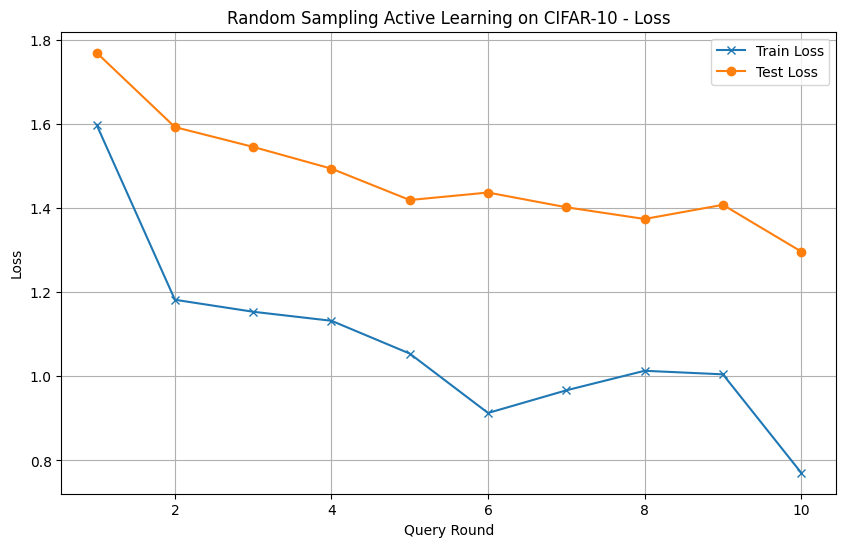

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_random, label='Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_random, label='Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Random Sampling Active Learning on CIFAR-10 - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/random_sampling_loss_cifar.png')

### Dataset-2: MNIST

In [27]:
mnist_labeled_indices = mnist_indices[:initial_labeled_size].tolist()
mnist_unlabeled_indices = mnist_indices[initial_labeled_size:].tolist()

train_losses_random = []
test_losses_random = []

n_queries = 10
query_batch_size = 500
epochs_per_round = 5

for round_num in range(n_queries):
    print(f"\n=== Random Sampling Round {round_num + 1}/{n_queries} ===")
    
    mnist_train_loader = get_dataloader(train_data=mnist_train_data, 
                                  indices=mnist_labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    model = SimpleCNN(dim=28, in_channels=1)
    train_model(model, mnist_train_loader, device=device, epochs=epochs_per_round)
    
    train_loss = compute_loss([model], mnist_train_loader, device)
    test_loss = compute_loss([model], mnist_test_loader, device)
    train_losses_random.append(train_loss)
    test_losses_random.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    if len(mnist_unlabeled_indices) == 0:
        break

    selected_indices = query_random_sampling(mnist_unlabeled_indices, query_batch_size)
    
    mnist_labeled_indices.extend(selected_indices)
    mnist_unlabeled_indices = list(set(mnist_unlabeled_indices) - set(selected_indices))


=== Random Sampling Round 1/10 ===


Train Loss: 0.0365 | Test Loss: 0.2801

=== Random Sampling Round 2/10 ===
Train Loss: 0.0282 | Test Loss: 0.1591

=== Random Sampling Round 3/10 ===
Train Loss: 0.0245 | Test Loss: 0.1672

=== Random Sampling Round 4/10 ===
Train Loss: 0.0156 | Test Loss: 0.1277

=== Random Sampling Round 5/10 ===
Train Loss: 0.0222 | Test Loss: 0.1355

=== Random Sampling Round 6/10 ===
Train Loss: 0.0242 | Test Loss: 0.1135

=== Random Sampling Round 7/10 ===
Train Loss: 0.0437 | Test Loss: 0.1481

=== Random Sampling Round 8/10 ===
Train Loss: 0.0177 | Test Loss: 0.0829

=== Random Sampling Round 9/10 ===
Train Loss: 0.0201 | Test Loss: 0.0824

=== Random Sampling Round 10/10 ===
Train Loss: 0.0121 | Test Loss: 0.0691


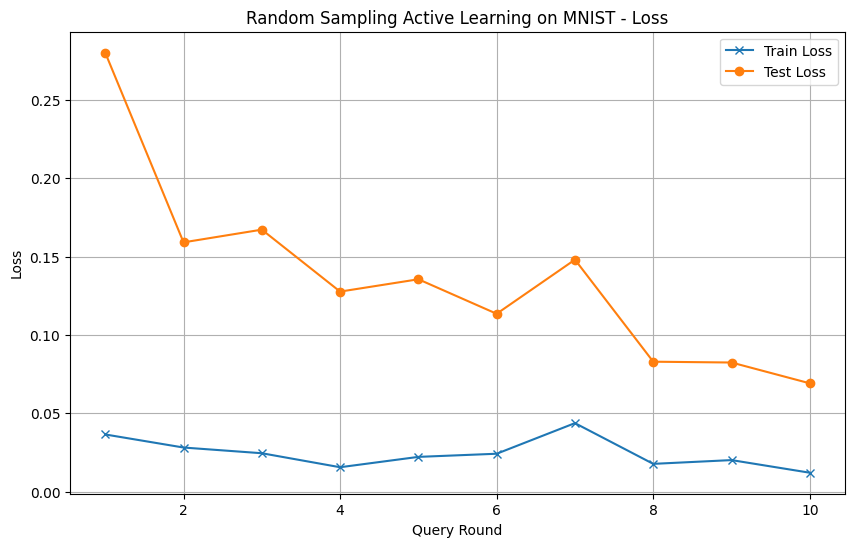

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_random, label='Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_random, label='Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Random Sampling Active Learning on MNIST - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/random_sampling_loss_mnist.png')

## Uncertainty Sampling

In [29]:
def query_uncertainty_sampling(model, train_data, unlabeled_indices, n_instances, device):
    model.eval()
    subset = Subset(train_data, unlabeled_indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False)

    all_probs = []
    for data, _ in loader:
        data = data.to(device)
        with torch.inference_mode():
            outputs = model(data)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

    all_probs = np.vstack(all_probs)
    uncertainty = 1 - np.max(all_probs, axis=1)
    selected_pos = np.argsort(uncertainty)[-n_instances:]
    selected_indices = [unlabeled_indices[i] for i in selected_pos]
    return selected_indices

### Dataset-1: CIFAR-10

In [56]:
indices = np.arange(len(cifar_train_data))
np.random.shuffle(indices)
initial_labeled_size = 1000
cifar_labeled_indices = cifar_indices[:initial_labeled_size].tolist()
cifar_unlabeled_indices = cifar_indices[initial_labeled_size:].tolist()

train_losses_uncertainty = []
test_losses_uncertainty = []

for round_num in range(n_queries):
    print(f"\n=== Uncertainty Sampling Round {round_num + 1}/{n_queries} ===")
    
    cifar_train_loader = get_dataloader(train_data=cifar_train_data, 
                                  indices=cifar_labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    model = SimpleCNN(dim=32, in_channels=3)
    train_model(model, cifar_train_loader, device=device, epochs=epochs_per_round)
    
    train_loss = compute_loss([model], cifar_train_loader, device)
    test_loss = compute_loss([model], cifar_test_loader, device)
    train_losses_uncertainty.append(train_loss)
    test_losses_uncertainty.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    if len(cifar_unlabeled_indices) == 0:
        break

    selected_indices = query_uncertainty_sampling(model, cifar_train_data, cifar_unlabeled_indices, query_batch_size, device)
    
    cifar_labeled_indices.extend(selected_indices)
    cifar_unlabeled_indices = list(set(cifar_unlabeled_indices) - set(selected_indices))


=== Uncertainty Sampling Round 1/10 ===


Train Loss: 1.2432 | Test Loss: 1.6681

=== Uncertainty Sampling Round 2/10 ===
Train Loss: 1.4056 | Test Loss: 1.6516

=== Uncertainty Sampling Round 3/10 ===
Train Loss: 1.3895 | Test Loss: 1.6059

=== Uncertainty Sampling Round 4/10 ===
Train Loss: 1.4313 | Test Loss: 1.4866

=== Uncertainty Sampling Round 5/10 ===
Train Loss: 1.2124 | Test Loss: 1.4838

=== Uncertainty Sampling Round 6/10 ===
Train Loss: 1.3069 | Test Loss: 1.4460

=== Uncertainty Sampling Round 7/10 ===
Train Loss: 1.3257 | Test Loss: 1.5089

=== Uncertainty Sampling Round 8/10 ===
Train Loss: 1.3267 | Test Loss: 1.3417

=== Uncertainty Sampling Round 9/10 ===
Train Loss: 1.4994 | Test Loss: 1.4809

=== Uncertainty Sampling Round 10/10 ===
Train Loss: 1.4119 | Test Loss: 1.5415


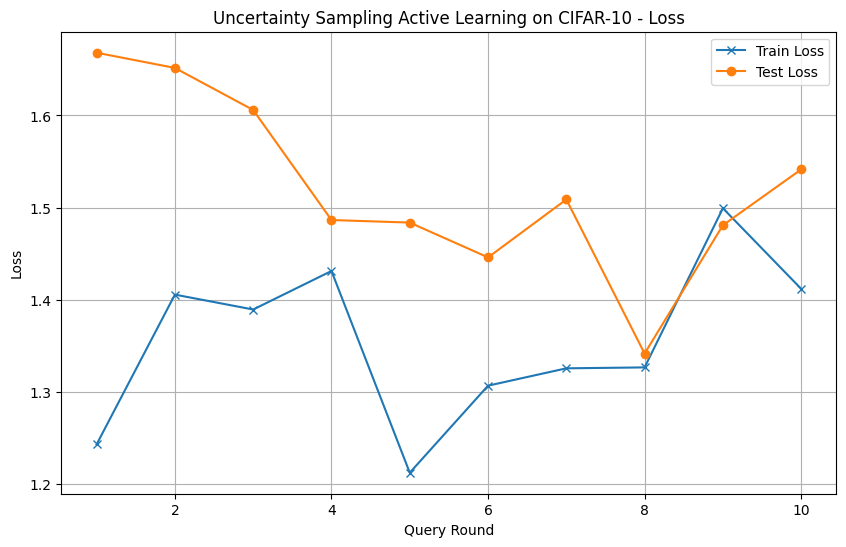

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_uncertainty, label='Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_uncertainty, label='Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Uncertainty Sampling Active Learning on CIFAR-10 - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/uncertainty_sampling_loss_cifar.png')

### Dataset-2: MNIST

In [32]:
initial_labeled_size = 1000
mnist_labeled_indices = mnist_indices[:initial_labeled_size].tolist()
mnist_unlabeled_indices = mnist_indices[initial_labeled_size:].tolist()

train_losses_uncertainty = []
test_losses_uncertainty = []

for round_num in range(n_queries):
    print(f"\n=== Uncertainty Sampling Round {round_num + 1}/{n_queries} ===")
    
    mnist_train_loader = get_dataloader(train_data=mnist_train_data, 
                                  indices=mnist_labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    model = SimpleCNN(dim=28, in_channels=1)
    train_model(model, mnist_train_loader, device=device, epochs=epochs_per_round)
    
    train_loss = compute_loss([model], mnist_train_loader, device)
    test_loss = compute_loss([model], mnist_test_loader, device)
    train_losses_uncertainty.append(train_loss)
    test_losses_uncertainty.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    if len(mnist_unlabeled_indices) == 0:
        break

    selected_indices = query_uncertainty_sampling(model, mnist_train_data, mnist_unlabeled_indices, query_batch_size, device)
    
    mnist_labeled_indices.extend(selected_indices)
    mnist_unlabeled_indices = list(set(mnist_unlabeled_indices) - set(selected_indices))


=== Uncertainty Sampling Round 1/10 ===


Train Loss: 0.0234 | Test Loss: 0.1785

=== Uncertainty Sampling Round 2/10 ===
Train Loss: 0.0370 | Test Loss: 0.1172

=== Uncertainty Sampling Round 3/10 ===
Train Loss: 0.1165 | Test Loss: 0.1020

=== Uncertainty Sampling Round 4/10 ===
Train Loss: 0.0688 | Test Loss: 0.0750

=== Uncertainty Sampling Round 5/10 ===
Train Loss: 0.0466 | Test Loss: 0.0449

=== Uncertainty Sampling Round 6/10 ===
Train Loss: 0.0660 | Test Loss: 0.0371

=== Uncertainty Sampling Round 7/10 ===
Train Loss: 0.0908 | Test Loss: 0.0329

=== Uncertainty Sampling Round 8/10 ===
Train Loss: 0.0799 | Test Loss: 0.0326

=== Uncertainty Sampling Round 9/10 ===
Train Loss: 0.0973 | Test Loss: 0.0331

=== Uncertainty Sampling Round 10/10 ===
Train Loss: 0.0713 | Test Loss: 0.0277


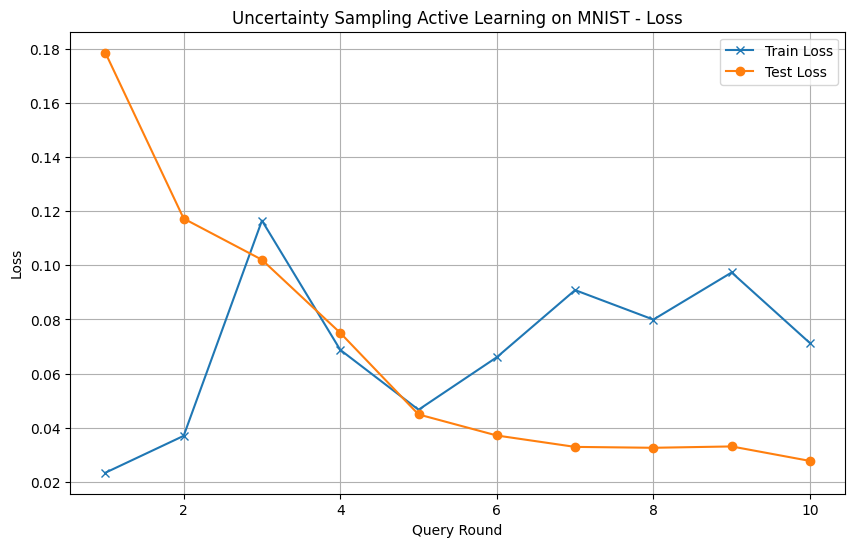

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_uncertainty, label='Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_uncertainty, label='Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Uncertainty Sampling Active Learning on MNIST - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/uncertainty_sampling_loss_mnist.png')

## Query By Committee

In [9]:
def committee_predict(committee, loader, device):
    all_probs = []
    for model in committee:
        model.eval()
        probs = []
        for data, _ in loader:
            data = data.to(device)
            with torch.inference_mode():
                outputs = model(data)
                prob = F.softmax(outputs, dim=1).cpu().numpy()
            probs.append(prob)
        probs = np.vstack(probs)
        all_probs.append(probs)
    all_probs = np.mean(all_probs, axis=0)  # Average probabilities over committee members
    preds = np.argmax(all_probs, axis=1)
    return preds

In [10]:
def query_qbc(committee, train_data, unlabeled_indices, n_instances, device):
    subset = Subset(train_data, unlabeled_indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False)
    all_predictions = []
    for model in committee:
        model.eval()
        predictions = []
        for data, _ in loader:
            data = data.to(device)
            with torch.inference_mode():
                outputs = model(data)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.append(preds)
        all_predictions.append(np.concatenate(predictions))
    all_predictions = np.array(all_predictions).T  # Shape (n_samples, n_committee)
    entropies = []
    for votes in all_predictions:
        unique, counts = np.unique(votes, return_counts=True)
        probs = counts / len(committee)
        entropy = -np.sum(probs * np.log(probs + 1e-10))  # Add epsilon to avoid log(0)
        entropies.append(entropy)
    entropies = np.array(entropies)
    selected_pos = np.argsort(entropies)[-n_instances:]
    selected_indices = [unlabeled_indices[i] for i in selected_pos]
    return selected_indices

### Dataset-1: CIFAR-10

In [60]:
cifar_labeled_indices = cifar_indices[:initial_labeled_size].tolist()
cifar_unlabeled_indices = cifar_indices[initial_labeled_size:].tolist()

train_losses_qbc = []
test_losses_qbc = []

n_committee = 3  # Number of models in the committee
n_queries = 10
query_batch_size = 500
epochs_per_round = 5

for round_num in range(n_queries):
    print(f"\n=== QBC Round {round_num + 1}/{n_queries} ===")
    committee = [SimpleCNN(dim=32, in_channels=3).to(device) for _ in range(n_committee)]
    cifar_train_loader = get_dataloader(cifar_train_data, cifar_labeled_indices, batch_size=64, shuffle=True)
    for model in committee:
        train_model(model, cifar_train_loader, device, epochs=epochs_per_round)
    train_loss = compute_loss(committee, cifar_train_loader, device)
    test_loss = compute_loss(committee, cifar_test_loader, device)
    train_losses_qbc.append(train_loss)
    test_losses_qbc.append(test_loss)
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    if len(cifar_unlabeled_indices) == 0:
        break
    selected_indices = query_qbc(committee, cifar_train_data, cifar_unlabeled_indices, query_batch_size, device)
    cifar_labeled_indices.extend(selected_indices)
    cifar_unlabeled_indices = list(set(cifar_unlabeled_indices) - set(selected_indices))


=== QBC Round 1/10 ===


Train Loss: 1.4364 | Test Loss: 1.6721

=== QBC Round 2/10 ===
Train Loss: 1.3331 | Test Loss: 1.5535

=== QBC Round 3/10 ===
Train Loss: 1.2213 | Test Loss: 1.4500

=== QBC Round 4/10 ===
Train Loss: 1.3342 | Test Loss: 1.4308

=== QBC Round 5/10 ===
Train Loss: 1.2994 | Test Loss: 1.3905

=== QBC Round 6/10 ===
Train Loss: 1.0906 | Test Loss: 1.2899

=== QBC Round 7/10 ===
Train Loss: 1.1023 | Test Loss: 1.2458

=== QBC Round 8/10 ===
Train Loss: 1.0370 | Test Loss: 1.2158

=== QBC Round 9/10 ===
Train Loss: 1.0271 | Test Loss: 1.2025

=== QBC Round 10/10 ===
Train Loss: 0.9342 | Test Loss: 1.1542


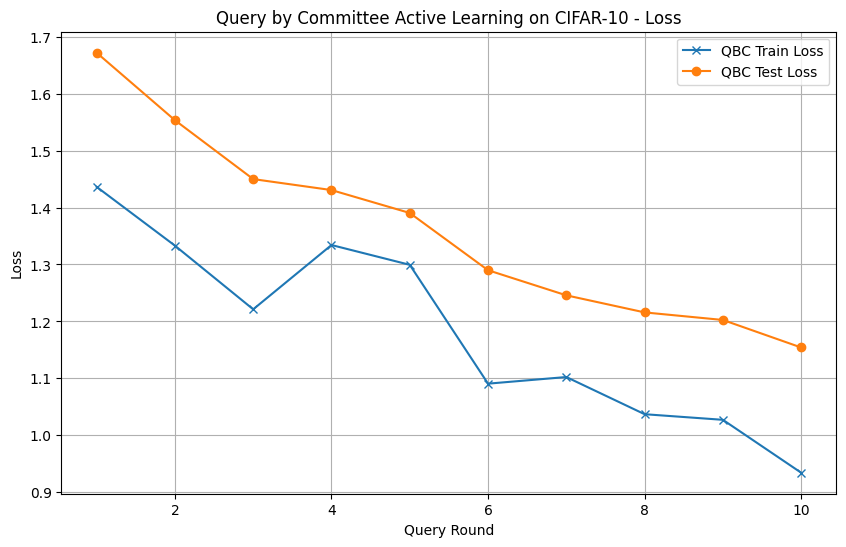

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_qbc, label='QBC Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_qbc, label='QBC Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Query by Committee Active Learning on CIFAR-10 - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/query_by_committee_loss_cifar.png')

### Dataset-2: MNIST

In [12]:
mnist_labeled_indices = mnist_indices[:initial_labeled_size].tolist()
mnist_unlabeled_indices = mnist_indices[initial_labeled_size:].tolist()

train_losses_qbc = []
test_losses_qbc = []

n_committee = 3  # Number of models in the committee
n_queries = 10
query_batch_size = 500
epochs_per_round = 5

for round_num in range(n_queries):
    print(f"\n=== QBC Round {round_num + 1}/{n_queries} ===")
    committee = [SimpleCNN(dim=28, in_channels=1).to(device) for _ in range(n_committee)]
    mnist_train_loader = get_dataloader(mnist_train_data, mnist_labeled_indices, batch_size=64, shuffle=True)
    for model in committee:
        train_model(model, mnist_train_loader, device, epochs=epochs_per_round)
    train_loss = compute_loss(committee, mnist_train_loader, device)
    test_loss = compute_loss(committee, mnist_test_loader, device)
    train_losses_qbc.append(train_loss)
    test_losses_qbc.append(test_loss)
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    if len(mnist_unlabeled_indices) == 0:
        break
    selected_indices = query_qbc(committee, mnist_train_data, mnist_unlabeled_indices, query_batch_size, device)
    mnist_labeled_indices.extend(selected_indices)
    mnist_unlabeled_indices = list(set(mnist_unlabeled_indices) - set(selected_indices))


=== QBC Round 1/10 ===


Train Loss: 0.0090 | Test Loss: 0.1707

=== QBC Round 2/10 ===
Train Loss: 0.0238 | Test Loss: 0.0878

=== QBC Round 3/10 ===
Train Loss: 0.0400 | Test Loss: 0.0524

=== QBC Round 4/10 ===
Train Loss: 0.0377 | Test Loss: 0.0410

=== QBC Round 5/10 ===
Train Loss: 0.0298 | Test Loss: 0.0289

=== QBC Round 6/10 ===
Train Loss: 0.0367 | Test Loss: 0.0233

=== QBC Round 7/10 ===
Train Loss: 0.0337 | Test Loss: 0.0230

=== QBC Round 8/10 ===
Train Loss: 0.0348 | Test Loss: 0.0184

=== QBC Round 9/10 ===
Train Loss: 0.0572 | Test Loss: 0.0238

=== QBC Round 10/10 ===
Train Loss: 0.0398 | Test Loss: 0.0199


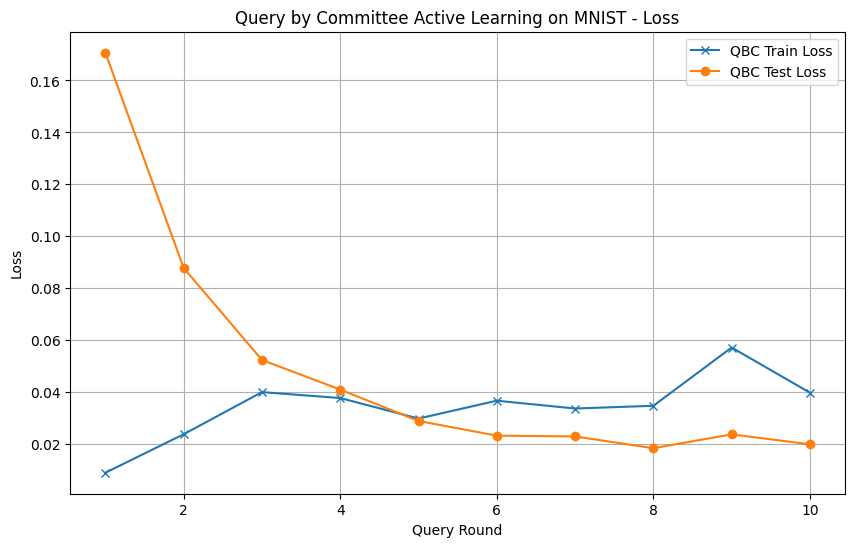

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_qbc, label='QBC Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_qbc, label='QBC Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Query by Committee Active Learning on MNIST - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/query_by_committee_loss_mnist.png')

## Expected Error Reduction

In [8]:
# Expected Error Reduction (EER)

def compute_expected_error_reduction(model, train_data, test_data, labeled_indices, unlabeled_indices, n_instances, device):
    # Compute the expected error reduction by comparing the loss reduction
    # between labeled and unlabeled instances.
    
    model.eval()
    
    # Create train and test loaders
    labeled_subset = Subset(train_data, labeled_indices)
    unlabeled_subset = Subset(train_data, unlabeled_indices)
    
    labeled_loader = DataLoader(labeled_subset, batch_size=64, shuffle=False)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=64, shuffle=False)
    
    # Compute current test loss with the labeled data
    train_loss_labeled = compute_loss([model], labeled_loader, device)
    test_loss_labeled = compute_loss([model], test_loader, device)
    
    # Calculate the error reduction based on the unlabeled data
    errors_unlabeled = []
    for data, labels in unlabeled_loader:
        data, labels = data.to(device), labels.to(device)
        with torch.inference_mode():
            outputs = model(data)
            loss = F.cross_entropy(outputs, labels, reduction='mean')
        errors_unlabeled.append(loss.item())
    
    # Estimate expected error reduction by evaluating the unlabeled data
    error_reduction = np.mean(errors_unlabeled) - test_loss_labeled
    return error_reduction

In [10]:
indices = np.arange(len(train_data))
np.random.shuffle(indices)
initial_labeled_size = 1000
labeled_indices = indices[:initial_labeled_size].tolist()
unlabeled_indices = indices[initial_labeled_size:].tolist()

train_losses_eer = []
test_losses_eer = []

n_queries = 10
query_batch_size = 500
epochs_per_round = 5

for round_num in range(n_queries):
    print(f"\n=== EER Round {round_num + 1}/{n_queries} ===")
    
    train_loader = get_dataloader(train_data=train_data, 
                                  indices=labeled_indices, 
                                  batch_size=64,
                                  shuffle=True)
    
    # Train model on the current batch of labeled data
    model = SimpleCNN()
    train_model(model, train_loader, device=device, epochs=epochs_per_round)
    
    train_loss = compute_loss([model], train_loader, device)
    test_loss = compute_loss([model], test_loader, device)
    
    train_losses_eer.append(train_loss)
    test_losses_eer.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    # If no unlabeled data left, break out of loop
    if len(unlabeled_indices) == 0:
        break
    
    # Select next instances based on Expected Error Reduction
    selected_indices = query_uncertainty_sampling(model, unlabeled_indices, query_batch_size, device)
    
    labeled_indices.extend(selected_indices)
    unlabeled_indices = list(set(unlabeled_indices) - set(selected_indices))


=== EER Round 1/10 ===


Train Loss: 1.4299 | Test Loss: 1.7271


NameError: name 'query_uncertainty_sampling' is not defined

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), train_losses_eer, label='Train Loss', marker='x')
plt.plot(range(1, n_queries + 1), test_losses_eer, label='Test Loss', marker='o')
plt.xlabel('Query Round')
plt.ylabel('Loss')
plt.title('Expected Error Reduction Active Learning on CIFAR-10 - Loss')
plt.legend()
plt.grid(True)
plt.savefig('visuals/expected_error_reduction_loss.png')